# Elastic Metric for Cell Boundary Analysis

## Notebook setup

In [1]:
import os
import subprocess
os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

INFO: Using pytorch backend


Working directory:  /Volumes/GoogleDrive/My Drive/code/cells


## Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [174]:
from geomstats.learning.pca import TangentPCA

from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## Project-specific imports

In [4]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans

import cells.cells.datasets.experimental as experimental
import cells.cells.features.basic as basic
import cells.viz as viz

viz.init_matplotlib()

We import the space of curves shapes equipped with different elastic metrics:
- the square root velocity metric (SRV), which is the canonical elastic metrics,
- the generalized elastic metric with parameters a, b.

# Load the dataset of interest

We load an experimental cell dataset with `n_cells` and `n_sampling_points` sampled along the boundary of each cell. 

For faster notebook execution, use small value for `n_cells` and `n_sampling_points`.

In [5]:
n_cells = 50
n_sampling_points = 180

In [6]:
labels_a_name = "lines" # "surfaces"  # "lines" #
labels_b_name = "treatments" # # "mutations"  # "treatments" #

In [7]:
# cells, cell_shapes, labels_a, labels_b = experimental.load_mutated_retinal_cells(
#     n_cells=n_cells, n_sampling_points=n_sampling_points
# )

cells, cell_shapes, labels_a, labels_b = experimental.load_treated_osteosarcoma_cells(
    n_cells=n_cells, n_sampling_points=n_sampling_points
)

... Selecting only a random subset of 50 / 650 cells.
... Interpolating: Cell boundaries have 180 samplings points.
... Removing potential duplicate sampling points on cell boundaries.

- Cells and cell shapes: quotienting translation.
- Cell shapes: quotienting scaling (length).
- Cell shapes: quotienting rotation.


In [8]:
labels_a_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_a))}
labels_b_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_b))}

print(f"Dictionary associated to label \"{labels_a_name}\":")
print(labels_a_dict)
print(f"Dictionary associated to label \"{labels_b_name}\":")
print(labels_b_dict)

Dictionary associated to label "lines":
{'dlm8': 0, 'dunn': 1}
Dictionary associated to label "treatments":
{'control': 0, 'cytd': 1, 'jasp': 2}


## Define Shape Spaces

In [9]:
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric

ELASTIC_METRIC = {}
AS = [1, 2, 0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
BS = [0.5, 1, 0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric

# Sample Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [10]:
means = {}

means["Linear"] = CLOSED_CURVES_SPACE.projection(gs.mean(cells, axis=0))
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        point_type="matrix", 
        method="default").fit(cell_shapes).estimate_
for a, b in zip(AS, BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            point_type="matrix", 
            method="default").fit(cell_shapes).estimate_

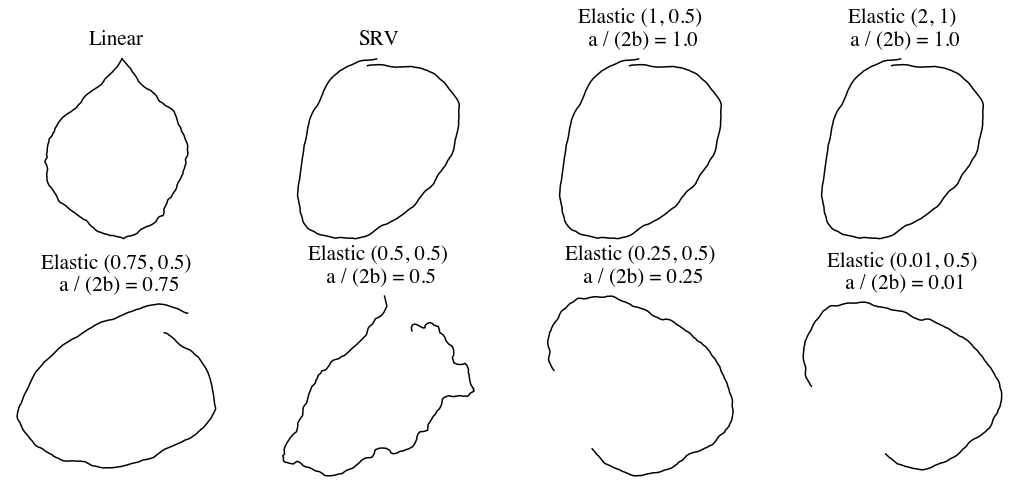

In [11]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

Since ratios of 1 give the same results as for the SRV metric, we only select AS, BS with a ratio that is not 1 for the elastic metrics.

In [12]:
NEW_AS = [0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
NEW_BS = [0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]

# Distances to the mean(s)

We compute the distances between:
- every cell in the dataset
- and the mean cell shape, according to the different metrics: Euclidean (Linear), SRV and Elastic Metrics.

In [13]:
dists = {}

dists["Linear"] = [gs.linalg.norm(means["Linear"] - cell).numpy() / n_sampling_points for cell in cells]

dists["SRV"] = [
    SRV_METRIC.dist(means["SRV"], cell).numpy() / n_sampling_points for cell in cells
]

for a, b in zip(NEW_AS, NEW_BS):
    dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(means[a, b], cell).numpy() / n_sampling_points for cell in cells
]

In [14]:
dists_summary = pd.DataFrame(
    data={
        labels_a_name: labels_a,
        labels_b_name: labels_b,
        "Linear": dists["Linear"],
        "SRV": dists["SRV"],
    }
)

for a, b in zip(NEW_AS, NEW_BS):
    dists_summary[f"Elastic({a}, {b})"] = dists[a, b]

In [15]:
dists_summary.head()

,lines,treatments,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,dlm8,control,1.773299,0.062188,0.062882,0.064161,0.062259,0.060230
1,dlm8,control,2.076607,0.067508,0.067433,0.068515,0.066615,0.064212
2,dlm8,control,2.225781,0.054143,0.054021,0.055434,0.053729,0.051445
3,dlm8,control,3.202560,0.040800,0.040886,0.040387,0.038044,0.036344
4,dlm8,control,1.789197,0.063550,0.063600,0.065127,0.063392,0.061117


In [182]:
xx = {}

for metric_name in ["Linear", "SRV"]:
    min_dists = gs.array(min(dists_summary[metric_name]))
    max_dists = gs.array(max(dists_summary[metric_name]))
    xx[metric_name] = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), 100)
xx["Linear"] = gs.linspace(0, 6, 100)

def hist_dists_to_means(labels, labels_name, label_color_incr):
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))

    for i, dist_name in enumerate(["Linear", "SRV"]):
        for i_lab, label in enumerate(np.unique(labels)):
            ds = dists_summary[dist_name][dists_summary[labels_name] == label]
            axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
            )
            kde = stats.gaussian_kde(ds)
            axs[i].plot(xx[metric_name], kde(xx[metric_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n {dist_name} mean\n colored by {labels_name}\n ")


    fig, axs = plt.subplots(1, len(NEW_AS), figsize=(18, 4), sharey=True)

    for i, (a, b) in enumerate(zip(NEW_AS, NEW_BS)):
        for i_lab, label in enumerate(np.unique(labels)):
            ds = dists_summary[f"Elastic({a}, {b})"][dists_summary[labels_name] == label]
            axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
            )
            kde = stats.gaussian_kde(ds)
            axs[i].plot(xx[metric_name], kde(xx[metric_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n Elastic({a}, {b}) mean\n colored by {labels_name}\n")

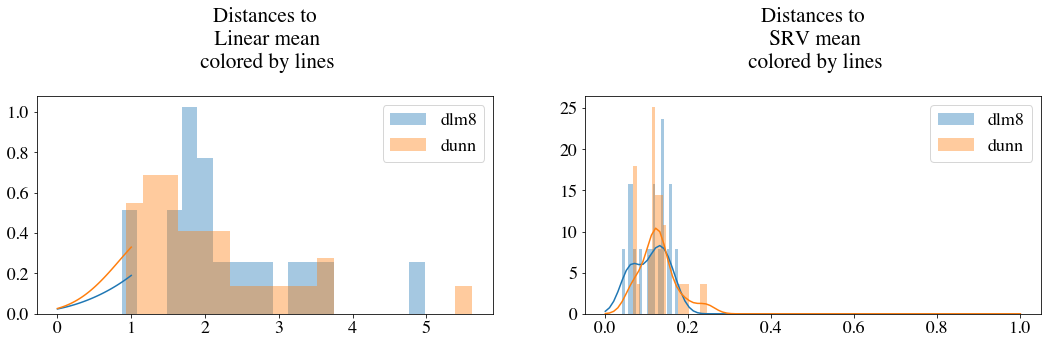

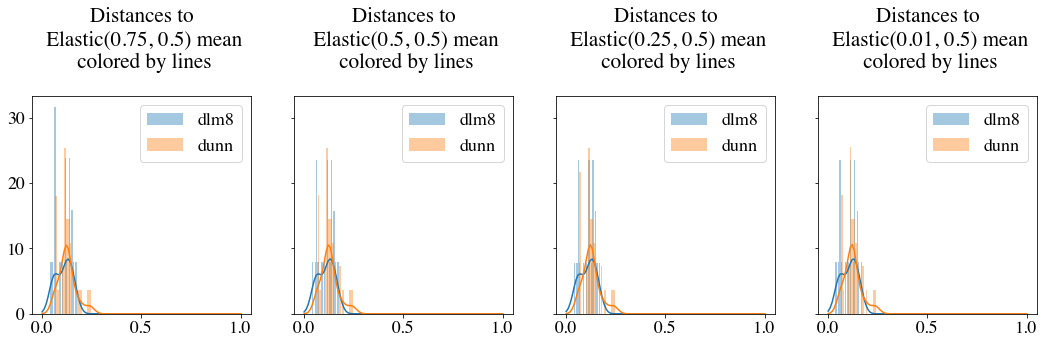

In [183]:
hist_dists_to_means(labels_a, labels_a_name, label_color_incr=0)

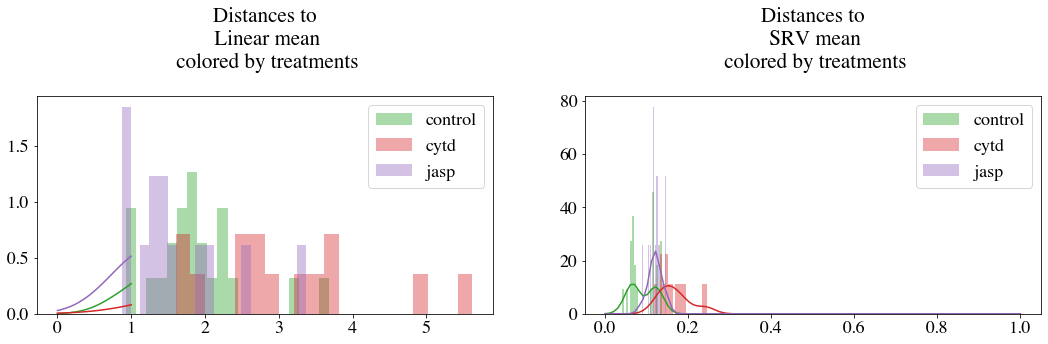

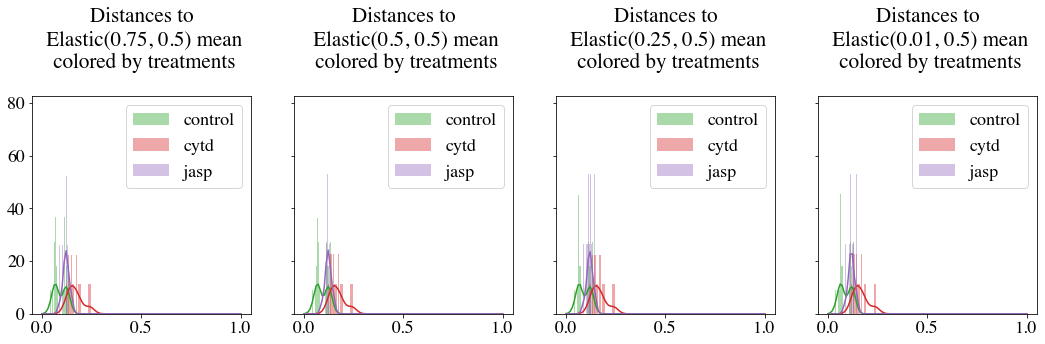

In [184]:
hist_dists_to_means(labels_b, labels_b_name, label_color_incr=2)

We observe that the histograms of distances vary between the:
- the histogram of distances to the linear mean
- the histogram of distances to the SRV mean.

However, the histograms of distances to the Elastic means show very little difference from the histogram to the SRV mean.

Thus, for the remainder of this analysis, we focus on the comparison between the Linear mean and the SRV mean.

# Clustering on distances with KMeans

We investigate whether KMeans performs differently when used with:
- the distances to the linear mean,
- the distances to the SRV mean.

In [20]:
def reorder_confusion_matrix(cmat):
    def _make_cost_m(cm):
        s = np.max(cm)
        return -cm + s

    indexes = linear_assignment(_make_cost_m(cmat))
    js = sorted(indexes, key=lambda x: x[0])[1]
    cm2 = cmat[:, js]
    return cm2

In [33]:
def confusion_kmean(labels, labels_name, labels_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for i, dist_name in enumerate(["Linear", "SRV"]):
        dists_arr = gs.expand_dims(gs.array(dists_summary[dist_name]), axis=1)
        kmeans = KMeans(n_clusters=len(labels_dict), random_state=0).fit(dists_arr)
        true_labels = [labels_dict[lab] for lab in labels]
        cm = confusion_matrix(true_labels, kmeans.labels_)
        cm = reorder_confusion_matrix(cm)

        axs[i].imshow(cm, interpolation="none", cmap="Blues")
        for (ii, jj), z in np.ndenumerate(cm):
            axs[i].text(jj, ii, z, ha="center", va="center")

        axs[i].axes.xaxis.set_ticks([])
        axs[i].axes.yaxis.set_ticks([])
        axs[i].set_xlabel("Kmeans labels")
        axs[i].set_ylabel("True labels")

        acc = 100 * (np.trace(cm) / np.sum(cm))
        axs[i].set_title(
            f"Clustering {labels_name} using \n  distances to {dist_name} mean \n Accuracy: {acc}%")

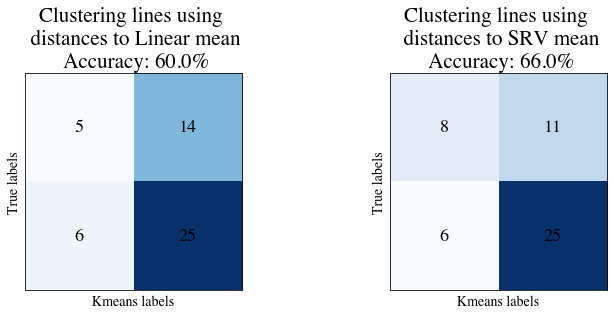

In [34]:
confusion_kmean(labels_a, labels_a_name, labels_a_dict)

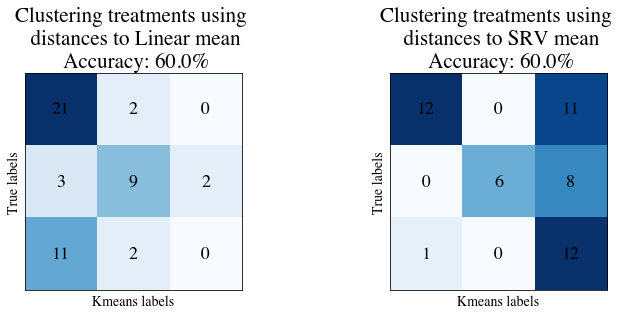

In [35]:
confusion_kmean(labels_b, labels_b_name, labels_b_dict)

# Dimension Reduction with PCA and tPCA

We investigate whether PCA and its Manifold equivalent (tangent PCA) performs differently when used with:
- the Euclidean (linear) metric,
- the SRV metric.

In [36]:
cells_flat = gs.reshape(cells, (len(cells), -1))

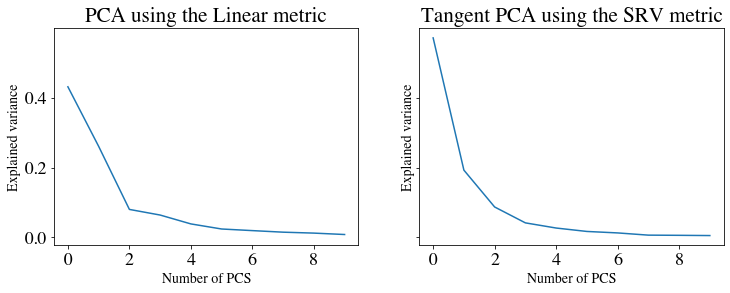

In [43]:
n_components = 10

pcas = {}
pcas["Linear"] = PCA(n_components=n_components).fit(cells_flat)
pcas["SRV"] = TangentPCA(n_components=n_components, metric=SRV_METRIC).fit(cell_shapes)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i, metric_name in enumerate(["Linear", "SRV"]):
    axs[i].plot(pcas[metric_name].explained_variance_ratio_)
    axs[i].set_xlabel("Number of PCS")
    axs[i].set_ylabel("Explained variance")
    tangent = ""
    if metric_name == "SRV":
        tangent = "Tangent "
    axs[i].set_title(f"{tangent}PCA using the {metric_name} metric")

We observe that the first principal components of the tangent PCA using the SRV metric captures a larger portion of the variance.

The first two components of the PCA with the Linear metric captures the following variance ratio:

In [45]:
sum(pcas["Linear"].explained_variance_ratio_[:1])

0.43123291260009816

The first two components of the tangent PCA with the SRV metric captures the following variance ratio:

In [47]:
sum(pcas["SRV"].explained_variance_ratio_[:1])

tensor(0.5712)

We explore the projections of the cell data on the two principal components of each PCA.

The projections on the PCA of the SRV metric are more informative, as they have captured more variance.

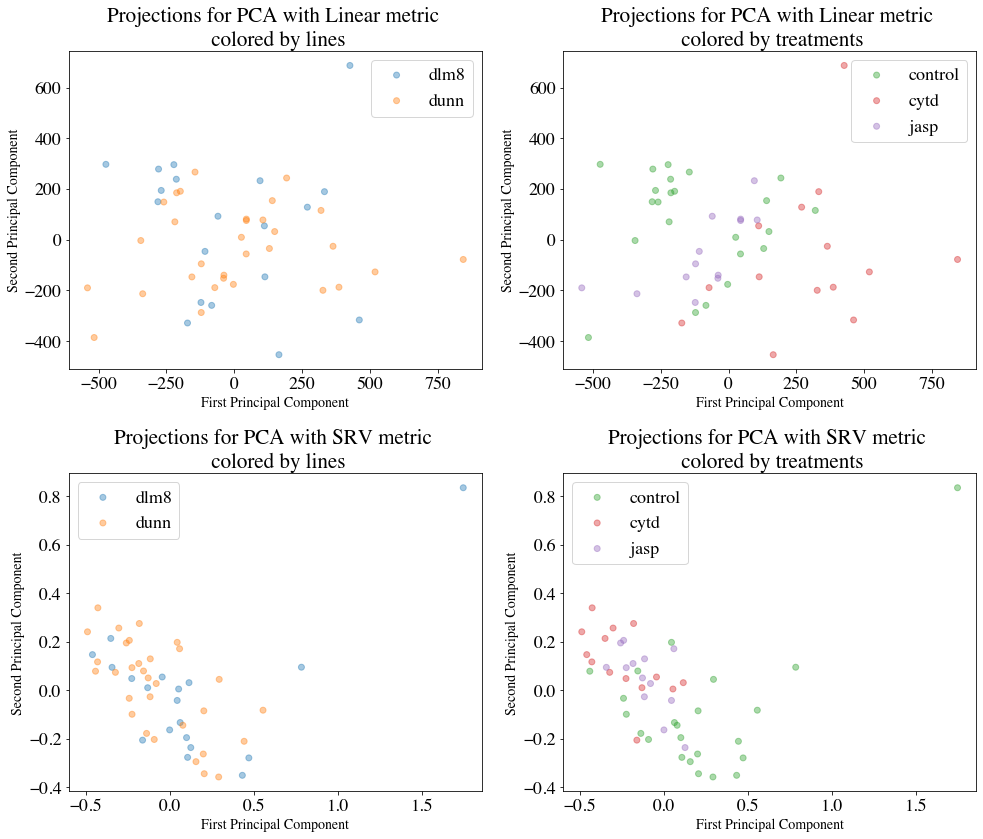

In [71]:
cell_transformed = {}
cell_transformed["Linear"] = pcas["Linear"].fit_transform(cells_flat)
cell_transformed["SRV"] = pcas["SRV"].fit_transform(cell_shapes)

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_a_dict, labels_b_dict], [labels_a, labels_b], [labels_a_name, labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            cell_tr = cell_transformed[metric_name][dists_summary[labels_name] == label]
            axs[i, j].scatter(
                cell_tr[:, 0],
                cell_tr[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                label=label
            )
            axs[i, j].set_xlabel("First Principal Component")
            axs[i, j].set_ylabel("Second Principal Component")
            axs[i, j].set_title(
                f"Projections for PCA with {metric_name} metric \n colored by {labels_name}")
            axs[i, j].legend()
plt.tight_layout()

In [97]:
times = np.arange(-0.5, 0.5, 0.1)

def plot_pc(geod, i_pc, metric_name):
    fig = plt.figure(figsize=(8, 1.3))
    for i, curve in enumerate(geod):
        fig.add_subplot(1, len(times), i + 1)
        plt.plot(curve[:, 0], curve[:, 1], c=f"C{i_pc+6}")
        plt.axis("equal")

        plt.axis("off")
        plt.tight_layout()
    fig.suptitle(f"Principal Component {i_pc} for {metric_name} metric")

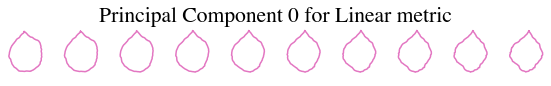

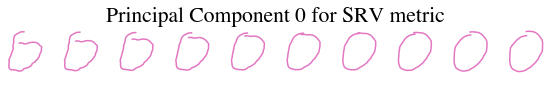

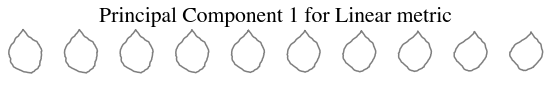

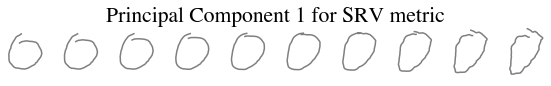

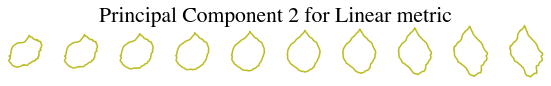

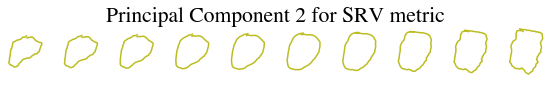

In [98]:
n_pcs = 3

for i_pc in range(n_pcs):
    pc = means["Linear"] + np.einsum(
        "n,ij->nij", 300 * times, pcas["Linear"].components_[i_pc].reshape((n_sampling_points, 2))
    )
    plot_pc(pc, i_pc=i_pc, metric_name="Linear")

    gpc = SRV_METRIC.geodesic(
        initial_curve=means["SRV"],
        initial_tangent_vec=pcas["SRV"].components_[i_pc].reshape((n_sampling_points, 2)),
    )(times)

    plot_pc(gpc, i_pc=i_pc, metric_name="SRV")

Traversing a principal component using the Euclidean (Linear) metric does not seem to provide interesting insights on the variations within the datasets of cells.

# Dimension Reduction via MDS

We examine another dimension reduction technique: Multidimensional Scaling (MDS).

MDS relies on computing the (pairwise) distances between any two pairs of cells, which we do first using just in time compilation (jit) to speed up the computations.

In [99]:
def linear_dist(cell1, cell2):
    return np.linalg.norm(cell1 - cell2) / n_sampling_points

def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points

In [100]:
@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i + 1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists

In [101]:
pairwise_dists = parallel_dist(cells.numpy(), dist_fun=linear_dist)

INFO: finding looplift candidates


In [105]:
# This takes 7min
pairwise_srv_dists = parallel_dist(cells, dist_fun=srv_dist)

In [108]:
mds = {}
pos = {}

mds["Linear"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["Linear"] = mds["Linear"].fit(pairwise_dists).embedding_

mds["SRV"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["SRV"] = mds["SRV"].fit(pairwise_dists_shape).embedding_

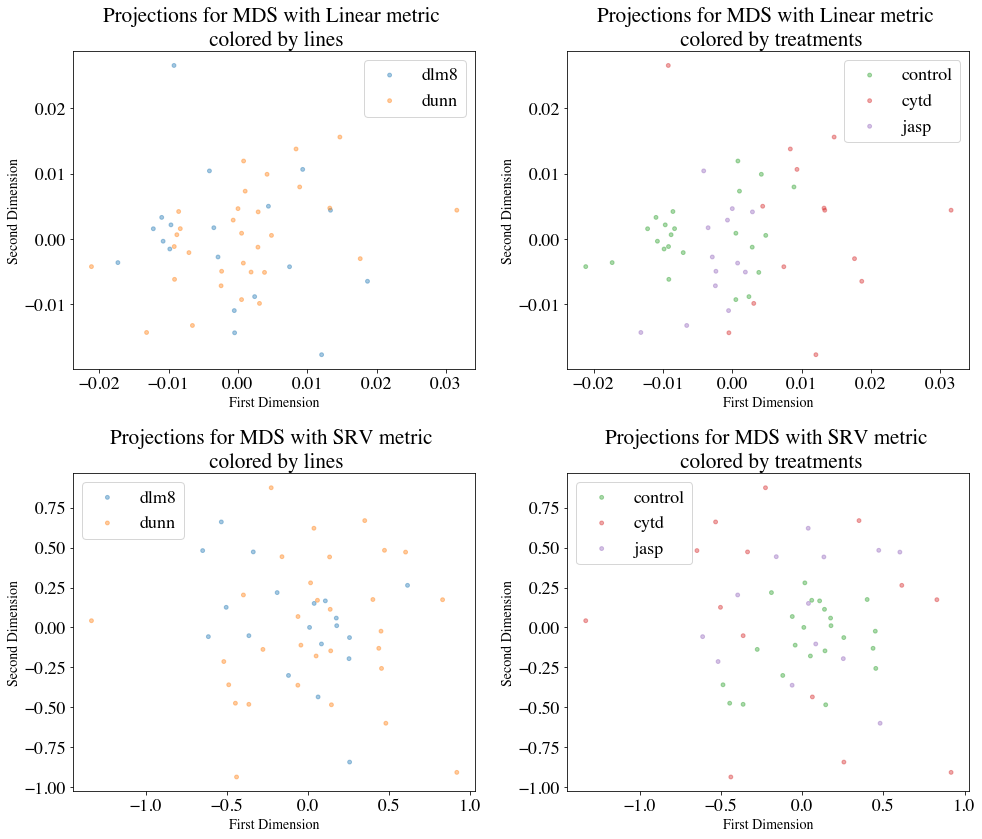

In [118]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_a_dict, labels_b_dict], [labels_a, labels_b], [labels_a_name, labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            position = pos[metric_name][dists_summary[labels_name] == label]
            if metric_name == "SRV":
                position = 1000 * position  # rescaling axis for display purposes
            axs[i, j].scatter(
                position[:, 0],
                position[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                s=15,
                label=label,
            )

            axs[i, j].set_xlabel("First Dimension")
            axs[i, j].set_ylabel("Second Dimension")
            axs[i, j].set_title(
                f"Projections for MDS with {metric_name} metric \n colored by {labels_name}")
            axs[i, j].legend()
plt.tight_layout()

Interestingly, the MDS with the distances computed from the SRV metric shows a concentric organization of the treatment. The distance to the origin (0, 0) of the space seems related to the treatment.

We sample cell shapes around circles of different radii to explore whether the polar angle contains relevant information.

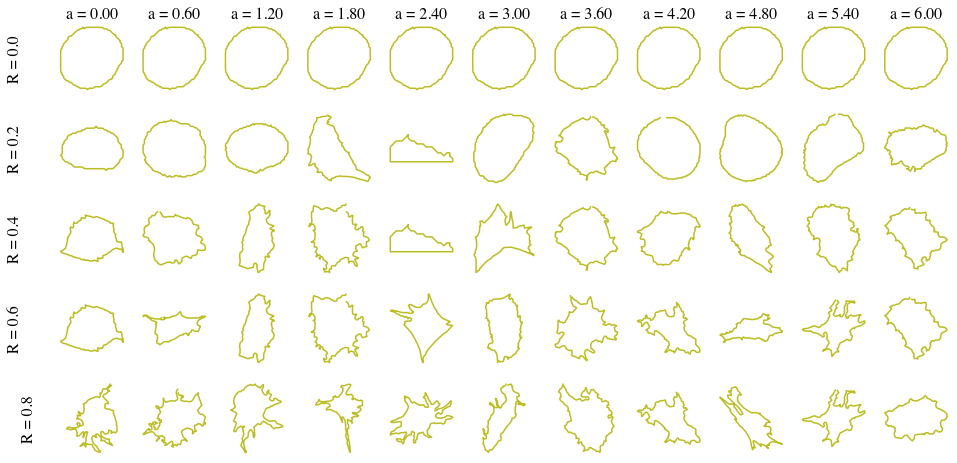

In [152]:
fig = plt.figure(figsize=(16, 8))
thetas = np.arange(0, 2 * np.pi, 0.6)
radii = np.arange(0, 0.001, 0.0002)

left, width = -.5, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

count = 0
for i_radius, radius in enumerate(radii):
    for i_theta, theta in enumerate(thetas):
        ax = fig.add_subplot(len(radii), len(thetas), count + 1)

        pos_theta = np.array([radius * np.cos(theta), radius * np.sin(theta)])
        dists_theta = np.linalg.norm(pos_theta - pos["SRV"], axis=1)
        assert len(dists_theta) == n_cells
        idx = np.argmin(dists_theta)

        ax.plot(cells[idx][:, 0], cells[idx][:, 1], c=f"C{i_pc+6}")
        ax.set_aspect("equal")
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if i_radius == 0:
            ax.set_title(f"a = {theta:.2f}", fontsize=16)
        if i_theta == 0:
            ax.text(-0.5, 0.5 * (bottom + top), f"R = {1000 * radius:.1f}", # rescaling for visualization
                horizontalalignment='right',
                verticalalignment='center',
                rotation='vertical',
                transform=ax.transAxes,
                fontsize=16)
        count += 1
    plt.ylabel(f"Radius: {radius}")

The following scatter plot shows that the radius in MDS space is the distance to the SRV mean shape.

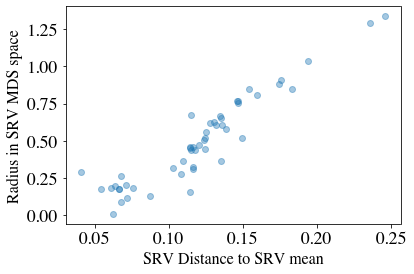

In [163]:
plt.scatter(dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1), alpha=0.4)
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Radius in SRV MDS space", fontsize=16);

# SRV distance and area, perimeter

In [161]:
areas = []
lengths = []
features = []
for cell in cells:
    area = basic.area(cell)
    length = basic.perimeter(cell)
    areas.append(area)
    lengths.append(length)
    features.append(area / length)

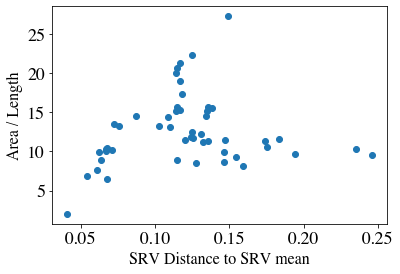

In [164]:
plt.scatter(dists_summary["SRV"], features);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area / Length", fontsize=16);

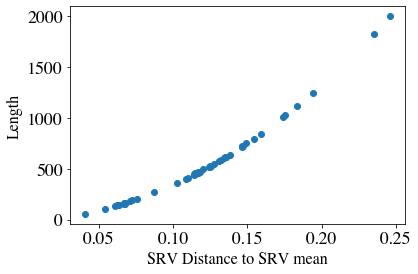

In [165]:
plt.scatter(dists_summary["SRV"], lengths);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Length", fontsize=16);

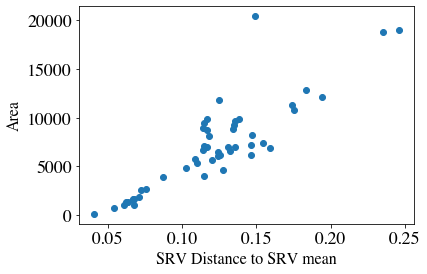

In [167]:
plt.scatter(dists_summary["SRV"], areas);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area", fontsize=16);